要件
- 学年の全生徒をそれぞれ１つのクラスに割り当てる
- 各クラスの生徒の人数は39人以上、40人以下とする
- 各クラスの男子生徒、女子生徒の人数は20人以下とする
- 各クラスの学力試験の平均点は、学年平均点±10点とする
- 各クラスにリーダー気質の生徒を2人以上割り当てる
- 特別支援が必要な生徒は各クラスに1人以下とする
- 特定ペアの生徒は同一クラスに割り当てない

In [1]:
import pandas as pd

In [2]:
df_students = pd.read_csv('./students.csv')
df_student_pairs = pd.read_csv('./student_pairs.csv')

In [3]:
df_students.head(2)

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379


In [4]:
df_student_pairs.head(2)

,student_id1,student_id2
0,118,189
1,72,50


In [5]:
df_students.score.describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<AxesSubplot:>

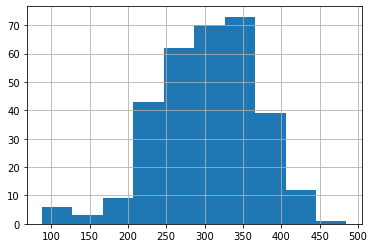

In [6]:
df_students.score.hist()

In [7]:
from pandas_profiling import ProfileReport

In [8]:
ProfileReport(df_students)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
import pulp

In [10]:
prob = pulp.LpProblem('CalssAssignmentProblem', pulp.LpMaximize)

In [11]:
students = df_students.student_id.tolist()
classes = [f'class_{i+1}' for i in range(8)]

In [12]:
student_class_pair = [(s, c) for s in students for c in classes]

In [13]:
student_class_pair[:3]

[(1, 'class_1'), (1, 'class_2'), (1, 'class_3')]

In [14]:
x = pulp.LpVariable.dicts('x', student_class_pair, cat='Binary')

In [15]:
# 各生徒は１つのクラスに割り当てる
for s in students:
    prob += pulp.lpSum(x[s, c] for c in classes) == 1

In [16]:
# 各クラスの生徒の人数は39人以上、40人以下
for c in classes:
    prob += pulp.lpSum(x[s, c] for s in students) >= 39
    prob += pulp.lpSum(x[s, c] for s in students) <= 40

In [17]:
# 各クラスの男子生徒、女子生徒の人数は20人以下とする
male_student_ids = df_students.query('gender == 1').student_id
female_student_ids = df_students.query('gender == 0').student_id
for c in classes:
    prob += pulp.lpSum([x[s, c] for s in male_student_ids]) <= 20
    prob += pulp.lpSum([x[s, c] for s in female_student_ids]) <= 20    

In [18]:
# 各クラスの学力試験の平均点は学年平均点±10点とする
score_mean = df_students.score.mean()
student_score_dict = {row.student_id: row.score for row in df_students.itertuples()}

for c in classes:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in students]) <= pulp.lpSum([x[s, c]*student_score_dict[s] for s in students])
    prob += pulp.lpSum([x[s, c] for s in students]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in students])

In [19]:
# 各クラスにリーダー気質の生徒を２人以上割り当てる
leader_students = df_students.query('leader_flag == 1').student_id

for c in classes:
    prob += pulp.lpSum([x[s, c] for s in leader_students]) >= 2

In [20]:
# 特別支援が必要な生徒は各クラスに１人以下とする
support_needed_students = df_students.query('support_flag == 1').student_id

for c in classes:
    prob += pulp.lpSum(x[s, c] for s in support_needed_students) <= 1

In [21]:
# 特定ペアの生徒は同一クラスに割り当てない
forbidden_student_pairs = [(row.student_id1, row.student_id2) for row in df_student_pairs.itertuples()]

for s1, s2 in forbidden_student_pairs:
    for c in classes:
        prob += x[s1, c] +x[s2, c] <= 1

In [22]:
# ソルバー
status = prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jianghui.ouyang/repository/PyOptBook/venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/9dfff15877a74f67b7497f582d9cbe84-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/9dfff15877a74f67b7497f582d9cbe84-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 20981 RHS
At line 21388 BOUNDS
At line 23934 ENDATA
Problem MODEL has 406 rows, 2545 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.05 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 390 rows, 2544 columns (2544 integer (2544 of which binary)) and 10392 elements
Cbc0038I Initial state - 16 integers unsatisfied sum - 5.00375
Cbc0038I Pass

In [23]:
status

1

In [24]:
pulp.LpStatus[status]

'Optimal'

In [25]:
class_student_result = {}
for c in classes:
    class_student_result[c] = [s for s in students if x[s, c].value() == 1]

In [67]:
for c_id, class_students in class_student_result.items():
    print('Class:', c_id)
    print('Student number:', len(class_students))
    print('Students:', class_student_result[c_id])

Class: class_1
Student numbers: 40
Students: [1, 4, 16, 19, 22, 30, 33, 37, 44, 51, 62, 66, 67, 73, 82, 89, 96, 100, 111, 135, 154, 172, 175, 201, 218, 234, 238, 242, 244, 258, 264, 269, 270, 284, 290, 294, 304, 305, 309, 315]
Class: class_2
Student numbers: 39
Students: [3, 5, 8, 11, 26, 27, 36, 45, 54, 57, 58, 60, 86, 90, 102, 106, 118, 142, 151, 162, 163, 171, 174, 187, 188, 191, 192, 195, 197, 212, 214, 225, 230, 232, 245, 268, 295, 303, 306]
Class: class_3
Student numbers: 40
Students: [6, 35, 39, 52, 71, 74, 88, 92, 105, 109, 117, 123, 128, 133, 140, 145, 150, 157, 170, 173, 180, 181, 199, 200, 203, 204, 216, 229, 236, 246, 256, 259, 261, 274, 291, 299, 302, 310, 311, 312]
Class: class_4
Student numbers: 40
Students: [15, 17, 18, 25, 28, 38, 40, 50, 56, 80, 93, 103, 113, 115, 120, 122, 127, 130, 132, 149, 159, 161, 178, 182, 183, 185, 189, 190, 211, 227, 228, 233, 276, 277, 280, 287, 288, 292, 308, 313]
Class: class_5
Student numbers: 40
Students: [10, 20, 21, 53, 64, 69, 70, 75,

## 検証


In [28]:
student_class_result = {s: c for s in students for c in classes if x[s, c].value() == 1}

In [29]:
df_students_results = df_students.assign(
    assigned_class = df_students.student_id.map(student_class_result)
).copy()

In [30]:
df_students_results

,student_id,gender,leader_flag,support_flag,score,assigned_class
0,1,0,0,0,335,class_1
1,2,1,0,0,379,class_8
2,3,0,0,0,350,class_2
3,4,0,0,0,301,class_1
4,5,1,0,0,317,class_2
...,...,...,...,...,...,...
313,314,0,0,0,244,class_8
314,315,1,0,0,309,class_1
315,316,0,0,0,239,class_7
316,317,1,0,0,356,class_5


In [74]:
df_students_results.groupby('assigned_class').agg({'score': ['mean', 'std']})

score            
                      mean         std
assigned_class                        
class_1         309.925000   51.349175
class_2         295.538462   38.018587
class_3         294.775000  106.732228
class_4         293.850000   42.010713
class_5         300.750000   73.809787
class_6         295.948718   44.872890
class_7         295.075000   47.867546
class_8         342.900000   74.968985

In [32]:
import matplotlib.pyplot as plt

In [33]:
fig = plt.figure(figsize=(12, 10))

<Figure size 864x720 with 0 Axes>

/var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/ipykernel_55264/1568177682.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


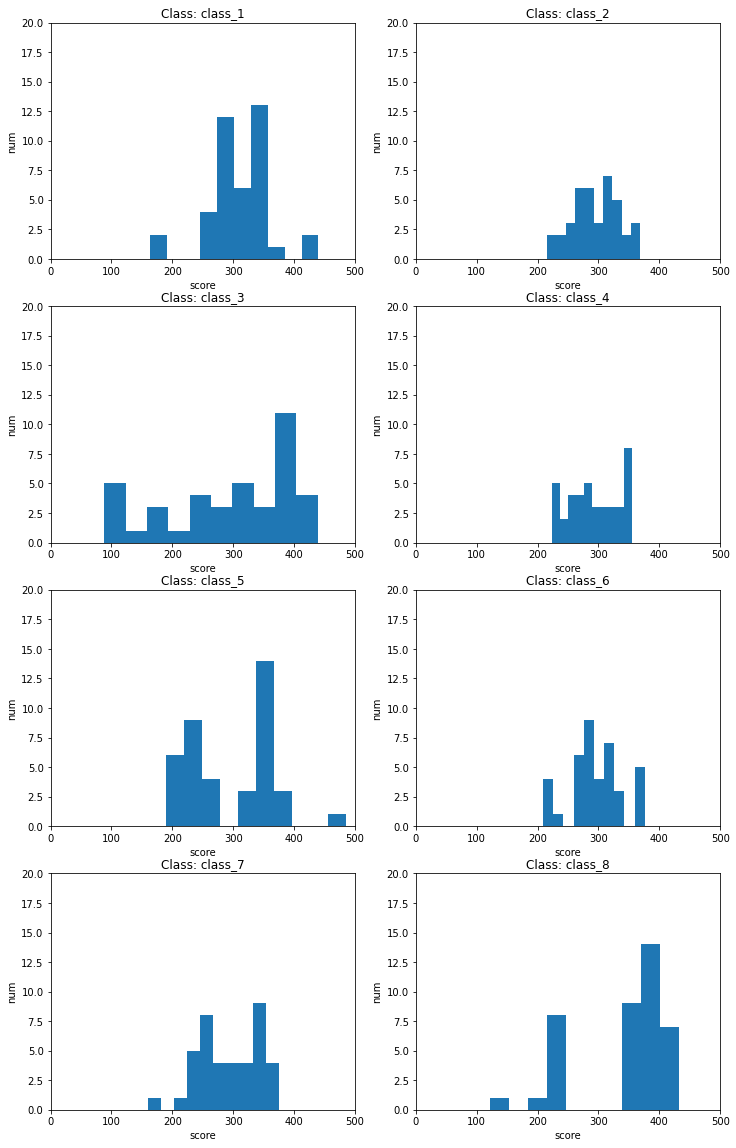

In [34]:
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(classes):
    _df = df_students_results.query(f'assigned_class == "{c}"')
    ax = fig.add_subplot(4, 2, i+1, xlabel='score', ylabel='num',
                        xlim=(0, 500), ylim=(0, 20), title=f'Class: {c}')
    ax.hist(_df['score'])
    plt.show()

In [35]:
# 学力をもとに順位を付与
df_students['score_rank'] = df_students['score'].rank(ascending=False, method='first').astype(int)

In [36]:
# 学力順にクラス編成し、init_assigned_classカラムを作成
class_id_map = {i: c for i, c in zip(range(8), classes)}
df_students['init_assigned_class'] = df_students.score_rank.apply(lambda rank: rank%8).map(class_id_map)

/var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/ipykernel_55264/880452839.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


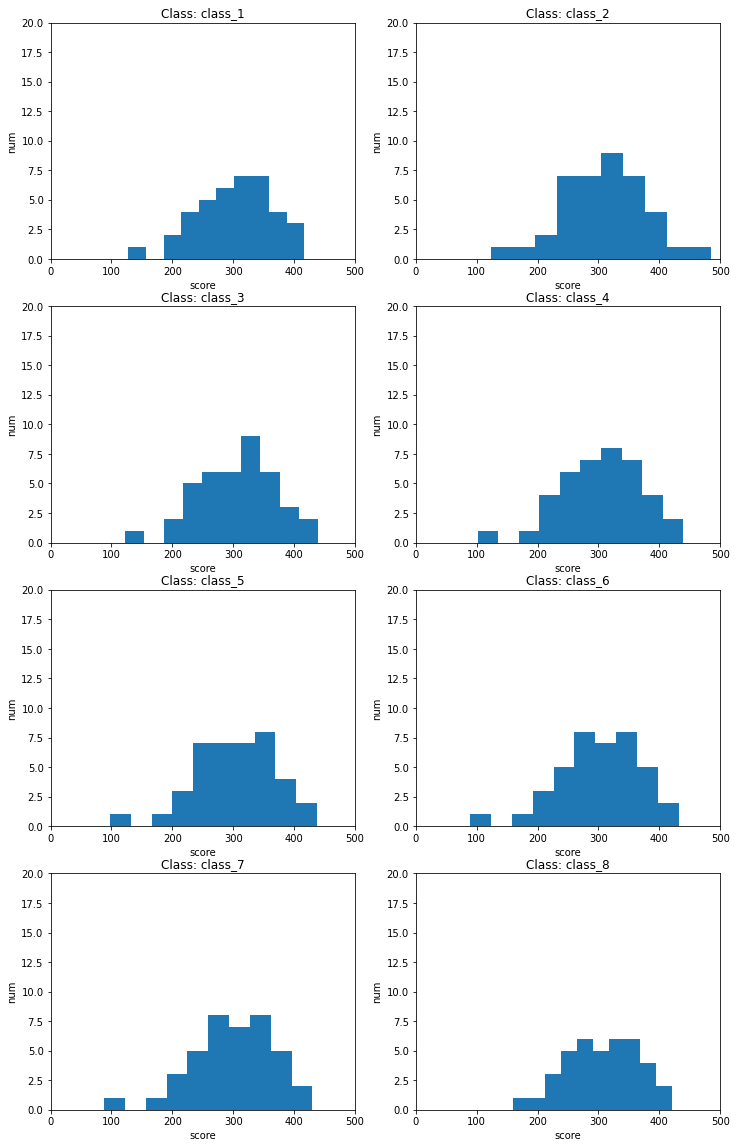

In [37]:
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(classes):
    _df = df_students.query(f'init_assigned_class == "{c}"')
    ax = fig.add_subplot(4, 2, i+1, xlabel='score', ylabel='num',
                        xlim=(0, 500), ylim=(0, 20), title=f'Class: {c}')
    ax.hist(_df['score'])
    plt.show()

# Maximize with initial distribution

In [38]:
prob = pulp.LpProblem('ClassAssignmentWithInitialAssignedClass', pulp.LpMaximize)

In [39]:
# 各生徒は１つのクラスに割り当てる
for s in students:
    prob += pulp.lpSum(x[s, c] for c in classes) == 1

In [40]:
# 各クラスの生徒の人数は39人以上、40人以下
for c in classes:
    prob += pulp.lpSum(x[s, c] for s in students) >= 39
    prob += pulp.lpSum(x[s, c] for s in students) <= 40

In [41]:
# 各クラスの男子生徒、女子生徒の人数は20人以下とする
male_student_ids = df_students.query('gender == 1').student_id
female_student_ids = df_students.query('gender == 0').student_id
for c in classes:
    prob += pulp.lpSum([x[s, c] for s in male_student_ids]) <= 20
    prob += pulp.lpSum([x[s, c] for s in female_student_ids]) <= 20    

In [42]:
# 各クラスの学力試験の平均点は学年平均点±10点とする
score_mean = df_students.score.mean()
student_score_dict = {row.student_id: row.score for row in df_students.itertuples()}

for c in classes:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in students]) <= pulp.lpSum([x[s, c]*student_score_dict[s] for s in students])
    prob += pulp.lpSum([x[s, c] for s in students]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in students])

In [43]:
# 各クラスにリーダー気質の生徒を２人以上割り当てる
leader_students = df_students.query('leader_flag == 1').student_id

for c in classes:
    prob += pulp.lpSum([x[s, c] for s in leader_students]) >= 2

In [44]:
# 特別支援が必要な生徒は各クラスに１人以下とする
support_needed_students = df_students.query('support_flag == 1').student_id

for c in classes:
    prob += pulp.lpSum(x[s, c] for s in support_needed_students) <= 1

In [45]:
# 特定ペアの生徒は同一クラスに割り当てない
forbidden_student_pairs = [(row.student_id1, row.student_id2) for row in df_student_pairs.itertuples()]

for s1, s2 in forbidden_student_pairs:
    for c in classes:
        prob += x[s1, c] +x[s2, c] <= 1

In [46]:
init_class_flag = {(s, c): 0 for s in students for c in classes}
for row in df_students.itertuples():
    init_class_flag[row.student_id, row.init_assigned_class] = 1

prob += pulp.lpSum(x[s, c] * init_class_flag[s, c] for s, c in student_class_pair)

In [47]:
%time
status = prob.solve()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jianghui.ouyang/repository/PyOptBook/venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/fdc6293ee5474a79aca503464f48260a-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/fdc6293ee5474a79aca503464f48260a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 21298 RHS
At line 21705 BOUNDS
At line 24250 ENDATA
Problem MODEL has 406 rows, 2544 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298 - 0.00 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 390 rows, 2544 columns (2544 integer (2544 of which binary)) and 10392 elements
Cutoff inc

In [48]:
pulp.LpStatus[status]

'Optimal'

In [49]:
student_class_result2 = {s: c for s in students for c in classes if x[s, c].value() == 1}

In [50]:
df_students_results['assigned_class2'] = df_students_results.student_id.map(student_class_result2)

/var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/ipykernel_55264/3730517497.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


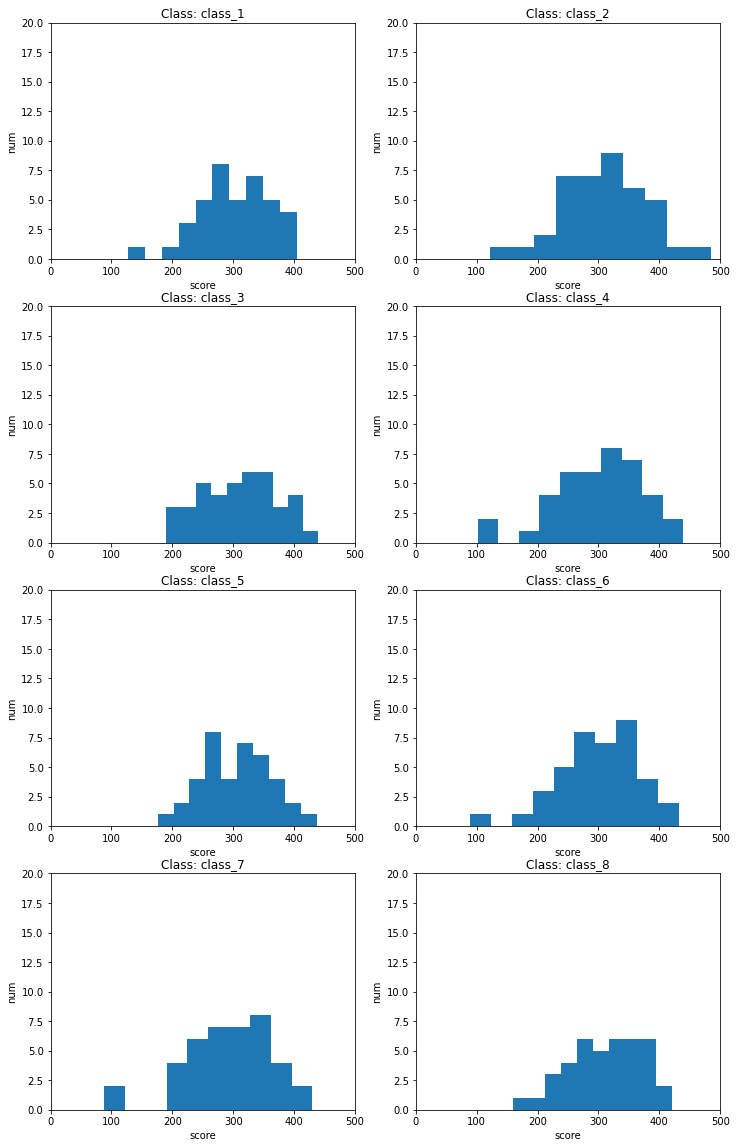

In [51]:
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(classes):
    _df = df_students_results.query(f'assigned_class2 == "{c}"')
    ax = fig.add_subplot(4, 2, i+1, xlabel='score', ylabel='num',
                        xlim=(0, 500), ylim=(0, 20), title=f'Class: {c}')
    ax.hist(_df['score'])
    plt.show()

# 初期クラス編成とできるだけ一致させる2
初期クラス編成ペアリストを使って最大化関数として解く

In [52]:
prob = pulp.LpProblem('ClassAssignmentWithInitialAssignedClass', pulp.LpMaximize)

In [53]:
# 各生徒は１つのクラスに割り当てる
for s in students:
    prob += pulp.lpSum(x[s, c] for c in classes) == 1

In [54]:
# 各クラスの生徒の人数は39人以上、40人以下
for c in classes:
    prob += pulp.lpSum(x[s, c] for s in students) >= 39
    prob += pulp.lpSum(x[s, c] for s in students) <= 40

In [55]:
# 各クラスの男子生徒、女子生徒の人数は20人以下とする
male_student_ids = df_students.query('gender == 1').student_id
female_student_ids = df_students.query('gender == 0').student_id
for c in classes:
    prob += pulp.lpSum([x[s, c] for s in male_student_ids]) <= 20
    prob += pulp.lpSum([x[s, c] for s in female_student_ids]) <= 20    

In [56]:
# 各クラスの学力試験の平均点は学年平均点±10点とする
score_mean = df_students.score.mean()
student_score_dict = {row.student_id: row.score for row in df_students.itertuples()}

for c in classes:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in students]) <= pulp.lpSum([x[s, c]*student_score_dict[s] for s in students])
    prob += pulp.lpSum([x[s, c] for s in students]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in students])

In [57]:
# 各クラスにリーダー気質の生徒を２人以上割り当てる
leader_students = df_students.query('leader_flag == 1').student_id

for c in classes:
    prob += pulp.lpSum([x[s, c] for s in leader_students]) >= 2

In [58]:
# 特別支援が必要な生徒は各クラスに１人以下とする
support_needed_students = df_students.query('support_flag == 1').student_id

for c in classes:
    prob += pulp.lpSum(x[s, c] for s in support_needed_students) <= 1

In [59]:
# 特定ペアの生徒は同一クラスに割り当てない
forbidden_student_pairs = [(row.student_id1, row.student_id2) for row in df_student_pairs.itertuples()]

for s1, s2 in forbidden_student_pairs:
    for c in classes:
        prob += x[s1, c] +x[s2, c] <= 1

In [60]:
init_assigned_class = [(row.student_id, row.init_assigned_class)for row in df_students.itertuples()]
prob += pulp.lpSum(x[s, c] for s, c in init_assigned_class)

In [61]:
%time
status = prob.solve()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jianghui.ouyang/repository/PyOptBook/venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/e70e0e15b93b465b81ed1b0261b5af4b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/e70e0e15b93b465b81ed1b0261b5af4b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 21298 RHS
At line 21705 BOUNDS
At line 24250 ENDATA
Problem MODEL has 406 rows, 2544 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298 - 0.00 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 390 rows, 2544 columns (2544 integer (2544 of which binary)) and 10392 elements
Cutoff inc

In [62]:
pulp.LpStatus[status]

'Optimal'

In [63]:
student_class_result2 = {s: c for s in students for c in classes if x[s, c].value() == 1}

In [64]:
df_students_results['assigned_class2'] = df_students_results.student_id.map(student_class_result2)

/var/folders/_x/r6xc9__d50sgdr9y8zj5bc5nbq0vnj/T/ipykernel_55264/3730517497.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


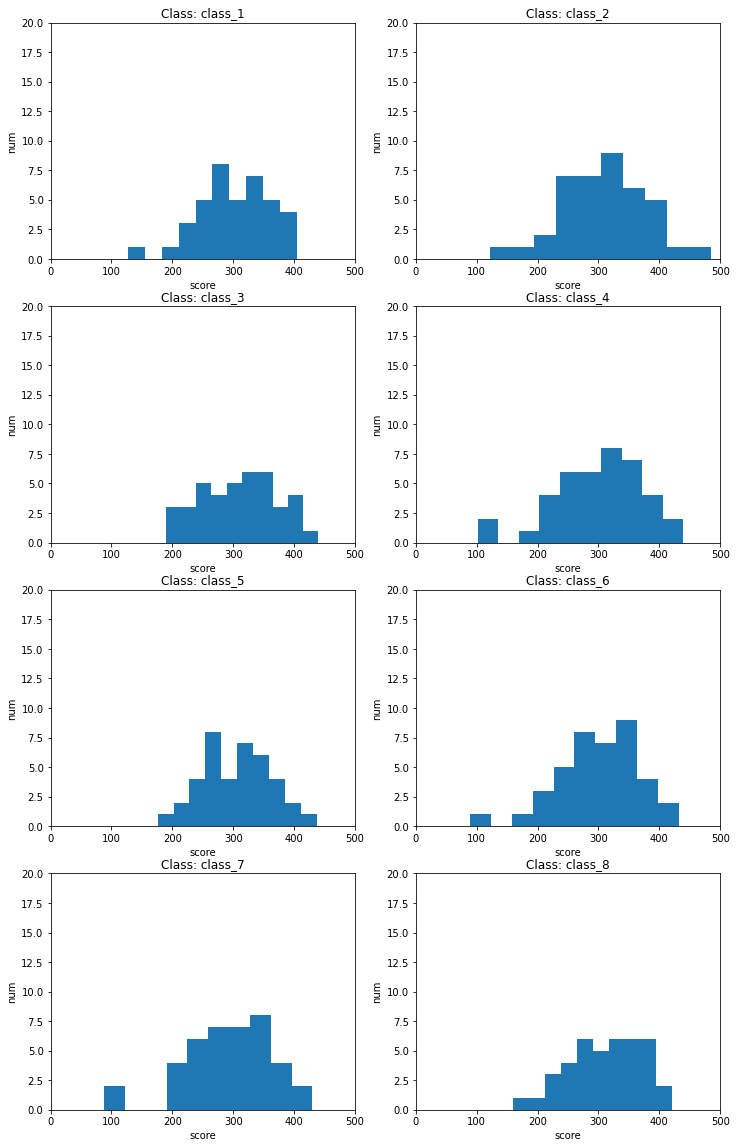

In [65]:
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(classes):
    _df = df_students_results.query(f'assigned_class2 == "{c}"')
    ax = fig.add_subplot(4, 2, i+1, xlabel='score', ylabel='num',
                        xlim=(0, 500), ylim=(0, 20), title=f'Class: {c}')
    ax.hist(_df['score'])
    plt.show()